# data reading

In [29]:
%reload_ext autoreload
%autoreload 2

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [30]:
df_train = read_data('data/train', 'training')
df_test = read_data('data/test', 'test')

# data exploration

In [31]:
df_train['label_text'] = df_train['label'].map({0: "non-harmful",
                                                1: "cyberbullying",
                                                2: "hate-speech"})

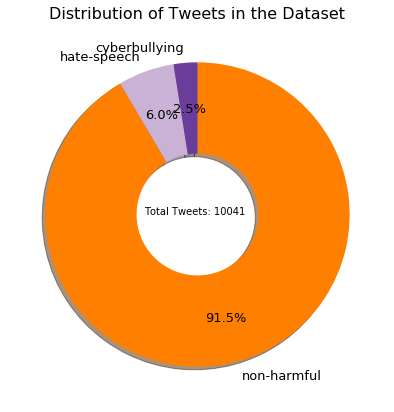

In [32]:
plt.figure(figsize = (7,7))
sorted_counts = df_train['label_text'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 13}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df_train.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

### create validation set for model validaiton during training

In [34]:
X_train, y_train = df_train[['text']], df_train[['label']]
X_test, y_test = df_test[['text']], df_test[['label']]

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                 y_train, 
                                                 random_state=42)

print('Number of rows in the total set: {}'.format(df_train.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 10041
Number of rows in the training set: 7530
Number of rows in the test set: 1000


# data cleaning

In [35]:
def clean_tweet(tweet):
    """
    Function that cleans a single tweet
    """
    entry = SentenceCleaner(tweet)
    entry.html_tag()
    entry.urls()
    entry.handle()
    entry.hashtag()
    entry.tolowercase()
    return entry.sentence

def clean_set(df):
    """
    Function that cleans an entire dataset 
    :param df: column of tweets
    :return: cleaned column
    
    """

In [41]:
X_train = X_train['text'].apply(clean_tweet)
X_val = X_val['text'].apply(clean_tweet)
X_test = X_test['text'].apply(clean_tweet)

# pre-trained Polish Bert embeddings

In [45]:
import torch
from tokenizers import SentencePieceBPETokenizer
from tokenizers.processors import RobertaProcessing
from transformers import RobertaModel, AutoModel


model_dir = "roberta_base_transformers"
tokenizer = SentencePieceBPETokenizer(f"{model_dir}/vocab.json", f"{model_dir}/merges.txt")
getattr(tokenizer, "_tokenizer").post_processor = RobertaProcessing(sep=("</s>", 2), cls=("<s>", 0))
model: RobertaModel = AutoModel.from_pretrained(model_dir)

In [44]:
max_seq = 100
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True).ids[:max_seq] for text in df.values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [46]:
%time
train_indices = tokenize_and_pad_text(X_train, max_seq)
val_indices = tokenize_and_pad_text(X_val, max_seq)
test_indices = tokenize_and_pad_text(X_test, max_seq)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [ ]:
%time

with torch.no_grad():
    X_train = model(train_indices)[0]  
    X_val = model(val_indices)[0]
    X_test = model(test_indices)[0]

In [63]:
model(test_indices[9:11])[0].shape

torch.Size([2, 100, 768])

In [49]:
X_test

0      użytkownik spoko, jak im duda z morawieckim za...
1      użytkownik użytkownik ale on tu nie miał szans...
2      użytkownik no czy prezes nie miał racji, mówią...
3      użytkownik użytkownik przecież to nawet nie je...
4      użytkownik użytkownik owszem podatki tak. ale ...
                             ...                        
995    użytkownik olej jak kto sie ubiera, patrz na s...
996    użytkownik to oczywiste byłyście dziś zajebist...
997    użytkownik duda może się przyjąć w białym domk...
998    użytkownik ty jesteś jebnięty, tła takiego par...
999    użytkownik użytkownik ale to nie  o tych, ci s...
Name: text, Length: 1000, dtype: object

In [50]:
output.shape

NameError: name 'output' is not defined

In [ ]:
%%time


In [ ]:
x.shape

In [ ]:
%%time

for sentence in X_test[:100]:
    input = tokenizer.encode(sentence)
    output = model(torch.tensor([input.ids]))[0]
    print(len(sentence.split(" ")), output.shape)
    break

In [ ]:
input = tokenizer.encode("Hej tam".split(" "))
input

In [ ]:
from torchnlp.word_to_vector import FastText
vectors = FastText('pl')

In [ ]:
# import fasttext
# import fasttext.util

# ft = fasttext.load_model('cc.en.300.bin')
# print(ft.get_dimension())

# fasttext.util.reduce_model(ft, 100)
# print(ft.get_dimension())

In [ ]:
max_ = 0
for i in X_test:
    if len(i.split(" "))>max_:
        max_ = len(i.split(" "))

In [ ]:
import fasttext
import fasttext.util

ft = fasttext.load_model('kgr10.plain.skipgram.dim100.neg10.bin')
print(ft.get_dimension())



In [ ]:
emoji[p] in ft.words

In [ ]:

# # get all words from model
# words = ft.get_words()

# with open('cc.pl.100.bin','w') as file_out:
    
#     # the first line must contain number of total words and vector dimension
#     file_out.write(str(len(words)) + " " + str(ft.get_dimension()) + "\n")

#     # line by line, you append vectors to VEC file
#     for w in tqdm(range(len(words))):
#         v = ft.get_word_vector(words[w])
#         vstr = ""
#         for vi in v:
#             vstr += " " + str(vi)
#         try:
#             file_out.write(words[w] + vstr+'\n')
#         except:
#             pass